# Momentum from scratch


In [1]:
!pip install mxnet
!pip install d2l

Traceback (most recent call last):
  File "/home/iserina/.local/bin/pip", line 7, in <module>
    from pip._internal import main
ModuleNotFoundError: No module named 'pip._internal'
Traceback (most recent call last):
  File "/home/iserina/.local/bin/pip", line 7, in <module>
    from pip._internal import main
ModuleNotFoundError: No module named 'pip._internal'


In [2]:
%matplotlib inline
import mxnet as mx
from mxnet import autograd
from mxnet import ndarray as nd
from mxnet import gluon
import random
import time

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt
import numpy as np

## Data

In [3]:
mx.random.seed(1)
random.seed(1)

# Generate data.
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
X = nd.random_normal(scale=1, shape=(num_examples, num_inputs))
y = true_w[0] * X[:, 0] + true_w[1] * X[:, 1] + true_b
y += .01 * nd.random_normal(scale=1, shape=y.shape)
dataset = gluon.data.ArrayDataset(X, y)


# Construct data iterator.
def data_iter(batch_size):
    idx = list(range(num_examples))
    random.shuffle(idx)
    for batch_i, i in enumerate(range(0, num_examples, batch_size)):
        j = nd.array(idx[i: min(i + batch_size, num_examples)])
        yield batch_i, X.take(j), y.take(j)

# Initialize model parameters.
def init_params():
    w = nd.random_normal(scale=1, shape=(num_inputs, 1))
    b = nd.zeros(shape=(1,))
    params = [w, b]
    vs = []
    for param in params:
        param.attach_grad()
        #
        vs.append(param.zeros_like())
    return params, vs

# Linear regression.
def net(X, w, b):
    return nd.dot(X, w) + b

# Loss function.
def square_loss(yhat, y):
    return (yhat - y.reshape(yhat.shape)) ** 2 / 2


In [4]:
##Momentum

In [5]:
def sgd_momentum(params, vs, lr, mom, batch_size):
    for param, v in zip(params, vs):
        v[:] = mom * v + lr * param.grad / batch_size
        param[:] = param - v

In [6]:
def train(batch_size, lr, mom, epochs, period):
    assert period >= batch_size and period % batch_size == 0
    [w, b], vs = init_params()
    total_loss = [np.mean(square_loss(net(X, w, b), y).asnumpy())]

    # Epoch starts from 1.
    for epoch in range(1, epochs + 1):
        # Decay learning rate.
        if epoch > 2:
            lr *= 0.1
        for batch_i, data, label in data_iter(batch_size):
            with autograd.record():
                output = net(data, w, b)
                loss = square_loss(output, label)
            loss.backward()
            sgd_momentum([w, b], vs, lr, mom, batch_size)
            if batch_i * batch_size % period == 0:
                total_loss.append(np.mean(square_loss(net(X, w, b), y).asnumpy()))
        print("Batch size %d, Learning rate %f, Epoch %d, loss %.4e" %
              (batch_size, lr, epoch, total_loss[-1]))
    print('w:', np.reshape(w.asnumpy(), (1, -1)),
          'b:', b.asnumpy()[0], '\n')
    x_axis = np.linspace(0, epochs, len(total_loss), endpoint=True)
    plt.semilogy(x_axis, total_loss)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

Batch size 10, Learning rate 0.200000, Epoch 1, loss 1.7184e-03
Batch size 10, Learning rate 0.200000, Epoch 2, loss 5.3016e-05
Batch size 10, Learning rate 0.020000, Epoch 3, loss 4.9890e-05
w: [[ 2.0013723 -3.4001465]] b: 4.2020493 



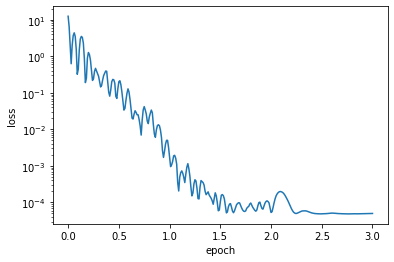

In [7]:
train(batch_size=10, lr=0.2, mom=0.9, epochs=3, period=10)

Batch size 10, Learning rate 0.200000, Epoch 1, loss 5.5321e-05
Batch size 10, Learning rate 0.200000, Epoch 2, loss 5.3054e-05
Batch size 10, Learning rate 0.020000, Epoch 3, loss 4.8548e-05
w: [[ 1.9995693 -3.3994997]] b: 4.2011065 



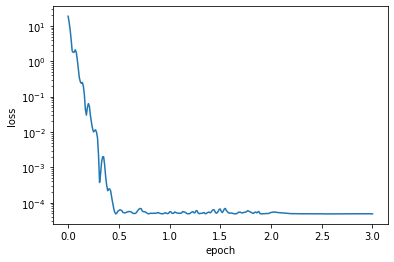

In [8]:
train(batch_size=10, lr=0.2, mom=0.7, epochs=3, period=10)

In [9]:
##Momentum with Gluon

In [10]:
import mxnet as mx
from mxnet import autograd
from mxnet import gluon
from mxnet import ndarray as nd
import numpy as np
import random

%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt


In [11]:
mx.random.seed(1)
random.seed(1)

# Generate data.
#num_inputs = 2
#num_examples = 1000
#true_w = [2, -3.4]
#true_b = 4.2
#X = nd.random_normal(scale=1, shape=(num_examples, num_inputs))
#y = true_w[0] * X[:, 0] + true_w[1] * X[:, 1] + true_b
#y += .01 * nd.random_normal(scale=1, shape=y.shape)
#dataset = gluon.data.ArrayDataset(X, y)

net = gluon.nn.Sequential()
net.add(gluon.nn.Dense(1))
square_loss = gluon.loss.L2Loss()

In [12]:
def train(batch_size, lr, mom, epochs, period):
    assert period >= batch_size and period % batch_size == 0
    net.collect_params().initialize(mx.init.Normal(sigma=1), force_reinit=True)
    # SGD with momentum.
    trainer = gluon.Trainer(net.collect_params(), 'sgd',
                            {'learning_rate': lr, 'momentum': mom})
    data_iter = gluon.data.DataLoader(dataset, batch_size, shuffle=True)
    total_loss = [np.mean(square_loss(net(X), y).asnumpy())]

    for epoch in range(1, epochs + 1):
        # Decay learning rate.
        if epoch > 2:
            trainer.set_learning_rate(trainer.learning_rate * 0.1)
        for batch_i, (data, label) in enumerate(data_iter):
            with autograd.record():
                output = net(data)
                loss = square_loss(output, label)
            loss.backward()
            trainer.step(batch_size)

            if batch_i * batch_size % period == 0:
                total_loss.append(np.mean(square_loss(net(X), y).asnumpy()))
        print("Batch size %d, Learning rate %f, Epoch %d, loss %.4e" %
              (batch_size, trainer.learning_rate, epoch, total_loss[-1]))

    print('w:', np.reshape(net[0].weight.data().asnumpy(), (1, -1)),
          'b:', net[0].bias.data().asnumpy()[0], '\n')
    x_axis = np.linspace(0, epochs, len(total_loss), endpoint=True)
    plt.semilogy(x_axis, total_loss)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

Batch size 10, Learning rate 0.200000, Epoch 1, loss 4.6256e-03
Batch size 10, Learning rate 0.200000, Epoch 2, loss 8.2535e-05
Batch size 10, Learning rate 0.020000, Epoch 3, loss 5.2069e-05
w: [[ 1.9990304 -3.3970413]] b: 4.2004313 



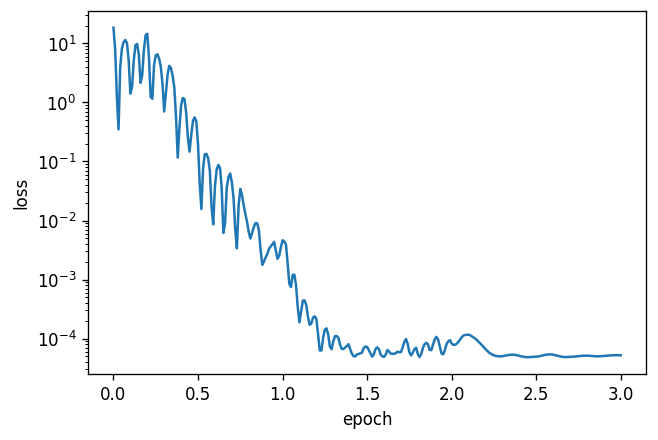

In [13]:
train(batch_size=10, lr=0.2, mom=0.9, epochs=3, period=10)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers, initializers, optimizers
from matplotlib import pyplot as plt

X = X.asnumpy()
y = y.asnumpy()

# MOMENTUM
model = Sequential()
model.add(Dense(1, kernel_initializer=initializers.RandomNormal(stddev=1),
                kernel_regularizer=regularizers.l2(1), input_shape=(num_inputs,)))
sgd = optimizers.SGD(lr=0.05, momentum=0.9)
model.compile(optimizer=sgd, loss='mean_squared_error')
history = model.fit(X, y, epochs=10, verbose=2, validation_split=0.2)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()